<a href="https://colab.research.google.com/github/aneeshc12/CV-A3/blob/main/2020111018_CV_A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# install and import
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Q1


In [4]:
# declare hyperparameters
batchSize = 64
numClasses = 10
lr = 0.001
numEpochs = 20

# cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# import CIFAR-10 and create torch dataloaders
allTransforms = transforms.Compose([transforms.Resize((32,32)),
                                     transforms.ToTensor(),
                                      # cifar 10 mean and std found online
                                     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                                          std=[0.2023, 0.1994, 0.2010])
                                     ])

# declare datasets
trainDataset = torchvision.datasets.CIFAR10(root = './data',
                                             train = True,
                                             transform = allTransforms,
                                             download=True)

testDataset = torchvision.datasets.CIFAR10(root = './data',
                                             train = False,
                                             transform = allTransforms,
                                             download=True)

# dataloaders
trainLoader = torch.utils.data.DataLoader(trainDataset,
                                          batch_size=batchSize,
                                          shuffle=True)

testLoader = torch.utils.data.DataLoader(testDataset,
                                          batch_size=batchSize,
                                          shuffle=True)

"""
# trainx: 50000 x 32 x 32 x 3
# trainy: 50000 x 1

# testx: 10000 x 32 x 32 x 3
# testy: 10000 x 1
"""

cuda


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


'\n# trainx: 50000 x 32 x 32 x 3\n# trainy: 50000 x 1\n\n# testx: 10000 x 32 x 32 x 3\n# testy: 10000 x 1\n'

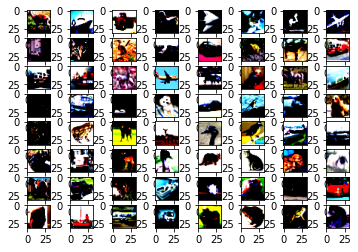

In [5]:
features, labels = next(iter(trainLoader))
for i, (img, label) in enumerate(zip(features, labels)):
  plt.subplot(8,8, i + 1)
  img = np.swapaxes(img, 0, 2)
  img = np.swapaxes(img, 0, 1)

  plt.imshow(img)

plt.show()

In [8]:
# main CNN class
class CNN(nn.Module):
  def __init__(self, numClasses=10):
    super(CNN, self).__init__()

    # images are 32x32x3

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
    # 32x32x32

    self.maxPool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    # 16x16x32

    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
    self.maxPool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(1600, 128)
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(128, numClasses)


  def forward(self, x):
    # 64 x 3 x 32 x 32
    
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.maxPool1(out)

    # 64 x 32 x 14 x 14

    out = self.conv3(out)
    out = self.conv4(out)
    out = self.maxPool2(out)

    # 64 x 64 x 5 x 5

    out = out.reshape(out.size(0), -1)
    # 64 X 1600

    out = self.fc1(out)
    out = self.relu1(out)
    out = self.fc2(out)

    # 64 x 10

    return out

In [9]:
# set up hyperparameters
model = CNN()
model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.005, momentum=0.9)

totalStep = len(trainLoader)

In [10]:
!mkdir -p modelCheckpoints

# train the CNN

def saveModel(model, epoch, path, loss):
  torch.save({
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': loss,
      }, path)
  
for epoch in range(numEpochs):
  for i, (images, labels) in enumerate(trainLoader):
    # shift to cuda
    images = images.to(device)
    labels = labels.to(device)

    # forward
    outputs = model(images)
    loss = criterion(outputs, labels)

    # backwards and optim
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print('Epoch [%d/%d], Loss: {:%.4f}' % (epoch+1, numEpochs, loss.item()))

  if epoch % 2 == 0:
    saveModel(model, epoch, "modelCheckpoints/Q1_CNN_epoch_" + str(epoch), loss.item())

Epoch [1/20], Loss: {:1.6706}
Epoch [2/20], Loss: {:1.4074}
Epoch [3/20], Loss: {:1.5136}
Epoch [4/20], Loss: {:1.3035}
Epoch [5/20], Loss: {:1.3984}
Epoch [6/20], Loss: {:0.6304}
Epoch [7/20], Loss: {:1.6570}
Epoch [8/20], Loss: {:1.3078}
Epoch [9/20], Loss: {:1.1862}
Epoch [10/20], Loss: {:1.0468}
Epoch [11/20], Loss: {:1.0241}
Epoch [12/20], Loss: {:1.0761}
Epoch [13/20], Loss: {:1.0149}
Epoch [14/20], Loss: {:0.5966}
Epoch [15/20], Loss: {:0.6586}
Epoch [16/20], Loss: {:0.7831}
Epoch [17/20], Loss: {:0.3889}
Epoch [18/20], Loss: {:0.8901}
Epoch [19/20], Loss: {:0.2610}
Epoch [20/20], Loss: {:0.5287}


In [12]:
# evaluate on train

with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in trainLoader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)

    # max confidence value is the predicted class
    _, predicted = torch.max(outputs.data, 1)
    # print(predicted)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print("Accuracy on %d training images: %.3f%%" % (50000, 100 * float(correct)/total))

Accuracy on 50000 training images: 83.194%


In [13]:
# evaluate on test

with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in testLoader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)

    # max confidence value is the predicted class
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print("Accuracy on %d training images: %.3f%%" % (10000, 100 * float(correct)/total))

Accuracy on 10000 training images: 67.970%


# Q2: visualising feature maps

4 conv layers found:
Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))

torch.Size([32, 32, 3])
4 feature maps of the following shapes: 
torch.Size([1, 32, 30, 30])
torch.Size([1, 32, 28, 28])
torch.Size([1, 64, 26, 26])
torch.Size([1, 64, 24, 24])

Feature map shapes
(30, 30)
(28, 28)
(26, 26)
(24, 24)


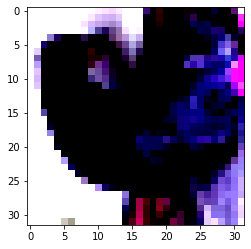

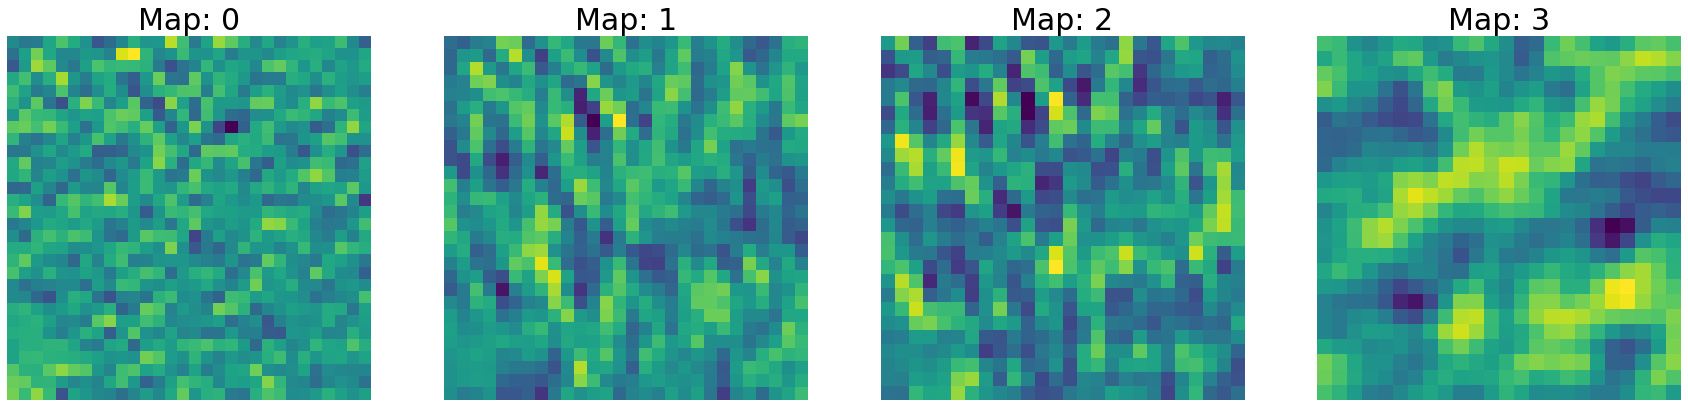

In [14]:
# extract all conv layers and their weights

from PIL import Image
import copy 

def visualiseFeatureMaps(inputImg, modelTransform, model):
  # get convs
  modelWeights = []
  convLayers = []

  cnt = 0
  for child in model.children():
    if type(child) == nn.Conv2d:
      cnt += 1
      modelWeights.append(child.weight)
      convLayers.append(child)
                    
    elif type(child) == nn.Sequential:
      for i in range(len(child)):
        for grandchild in child[i].children():
          if type(grandchild) == nn.Conv2d:
            cnt += 1
            modelWeights.append(grandchild.weight)
            convLayers.append(grandchild)

  print("%d conv layers found:" % cnt)
  for cl in convLayers:
    print(cl)
  print()

  # convert image, obtain maps
  print(inputImg.shape)
  inputImg = torch.swapaxes(inputImg, 0,2)
  T = transforms.ToPILImage()
  img = T(inputImg)
  
  img = modelTransform(img)
  img = img.unsqueeze(0)
  img = img.to(device)
  
  outputs = []
  names = []

  for layer in convLayers:
    img = layer(img)
    outputs.append(img)
    names.append(str(layer))

  print("%d feature maps of the following shapes: " % len(outputs))
  for featureMap in outputs:
    print(featureMap.shape)

  # convert 3d tensors to 2d
  finalMaps = []
  for featureMap in outputs:
    featureMap = featureMap.squeeze(0)
    bw = torch.sum(featureMap, axis=0)
    bw = bw / featureMap.shape[0]
    finalMaps.append(bw.data.cpu().numpy())

  print()
  print("Feature map shapes")
  for fm in finalMaps:
    print(fm.shape)

  fig = plt.figure(figsize=(30, 50))
  for i in range(len(finalMaps)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(finalMaps[i])
    a.axis("off")
    a.set_title("Map: %d" % i, fontsize=30)
  plt.plot()


imgs, _ = next(iter(trainLoader))

dispImg = copy.deepcopy(img)
dispImg = np.swapaxes(dispImg, 0, 2)
dispImg = np.swapaxes(dispImg, 0, 1)
dispImg = np.swapaxes(dispImg, 2, 1)
plt.imshow(dispImg)
plt.plot()

visualiseFeatureMaps(img, allTransforms, model)


# Q3: Ablations

In [15]:
from sklearn.metrics import f1_score
import time

def runAblation(model, batchSize=64, lr=0.001, numEpochs=20):
  initTime = time.time()

  ## redeclare data loaders
  

  # batchSize = 64
  numClasses = 10
  # lr = 0.001
  # numEpochs = 20

  # cuda
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  # import CIFAR-10 and create torch dataloaders
  allTransforms = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.ToTensor(),
                                        # cifar 10 mean and std found online
                                      transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                                            std=[0.2023, 0.1994, 0.2010])
                                      ])

  # declare datasets
  trainDataset = torchvision.datasets.CIFAR10(root = './data',
                                              train = True,
                                              transform = allTransforms,
                                              download=True)

  testDataset = torchvision.datasets.CIFAR10(root = './data',
                                              train = False,
                                              transform = allTransforms,
                                              download=True)

  # dataloaders
  trainLoader = torch.utils.data.DataLoader(trainDataset,
                                            batch_size=batchSize,
                                            shuffle=True)

  testLoader = torch.utils.data.DataLoader(testDataset,
                                            batch_size=batchSize,
                                            shuffle=True)
  

  ## 
  model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.005, momentum=0.9)
  totalStep = len(trainLoader)


  print(numEpochs)
  for epoch in range(numEpochs):
    for i, (images, labels) in enumerate(trainLoader):
      # shift to cuda
      images = images.to(device)
      labels = labels.to(device)

      # forward
      outputs = model(images)
      loss = criterion(outputs, labels)

      # backwards and optim
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    print('Epoch [%d/%d], Loss: {:%.4f}' % (epoch+1, numEpochs, loss.item()))


  f1 = 0.0
  accuracy = 0.0
  with torch.no_grad():
    correct = 0
    total = 0

    y_pred = []
    y_labels = []
    
    for images, labels in testLoader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)

      # max confidence value is the predicted class
      _, predicted = torch.max(outputs.data, 1)

      for p,l in zip(predicted, labels):
        y_pred.append(p.cpu())
        y_labels.append(l.cpu())

      total += labels.size(0)
      correct += (predicted == labels).sum().item()


  f1 = f1_score(y_labels, y_pred, average=None)
  accuracy = float(correct)/total
  print("Accuracy on %d training images: %.3f%%" % (10000, 100 * float(correct)/total))
  print("F1 score for all classes: ", f1)
  print()

  timeTaken = time.time() - initTime

  print("Time taken: %f minutes" % (float(timeTaken)/60))
  print()

  print("Feature maps: ")

  imgs, _ = next(iter(trainLoader))

  dispImg = copy.deepcopy(img)
  dispImg = np.swapaxes(dispImg, 0, 2)
  dispImg = np.swapaxes(dispImg, 0, 1)
  dispImg = np.swapaxes(dispImg, 2, 1)
  plt.imshow(dispImg)
  plt.plot()

  visualiseFeatureMaps(img, allTransforms, model)

  return f1, accuracy



## Abalations done:

1. Changing the number of layers
  - Vary number of conv layers
  - Vary number of fully connected layers

2. Changing conv filter size
  - Smaller conv filters
  - Larger conv filters

3. Dropout layers

4. Varying learning rate

5. Varying batch size

6. Varying the number of epochs




# Model defns


In [16]:
# more cnns

# more conv layers
class longerCNN(nn.Module):
  def __init__(self, numClasses=10):
    super(longerCNN, self).__init__()

    # images are 32x32x3

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
    self.maxPool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # 32x32x32
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3)
    self.conv4 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3)
    self.maxPool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    # 16x16x32

    self.conv5 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3)
    self.conv6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
    self.maxPool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(1600, 128)
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(128, numClasses)


  def forward(self, x):
    # 64 x 3 x 32 x 32
    
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.maxPool1(out)

    out = self.conv3(out)
    out = self.conv4(out)
    out = self.maxPool2(out)

    # 64 x 32 x 14 x 14

    out = self.conv5(out)
    out = self.conv6(out)
    out = self.maxPool3(out)

    # 64 x 64 x 5 x 5

    out = out.reshape(out.size(0), -1)
    # 64 X 1600

    out = self.fc1(out)
    out = self.relu1(out)
    out = self.fc2(out)

    # 64 x 10

    return out


# fewer conv layers
class shortCNN(nn.Module):
  def __init__(self, numClasses=10):
    super(shortCNN, self).__init__()

    # images are 32x32x3

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
    # 32x32x32

    self.maxPool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    # 16x16x32

    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.maxPool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(1600, 128)
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(128, numClasses)


  def forward(self, x):
    # 64 x 3 x 32 x 32
    
    out = self.conv1(x)
    out = self.maxPool1(out)

    # 64 x 32 x 14 x 14

    out = self.conv2(out)
    out = self.maxPool2(out)

    # 64 x 64 x 5 x 5

    out = out.reshape(out.size(0), -1)
    # 64 X 1600

    out = self.fc1(out)
    out = self.relu1(out)
    out = self.fc2(out)

    # 64 x 10

    return out


In [17]:
# changing filter size


# larger conv
class wideCNN(nn.Module):
  def __init__(self, numClasses=10):
    super(wideCNN, self).__init__()

    # images are 32x32x3

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5)
    # 32x32x32

    self.maxPool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    # 16x16x32

    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5)
    self.maxPool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(1600, 128)
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(128, numClasses)


  def forward(self, x):
    # 64 x 3 x 32 x 32
    
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.maxPool1(out)

    # 64 x 32 x 14 x 14

    out = self.conv3(out)
    out = self.conv4(out)
    out = self.maxPool2(out)

    # 64 x 64 x 5 x 5

    out = out.reshape(out.size(0), -1)
    # 64 X 1600

    out = self.fc1(out)
    out = self.relu1(out)
    out = self.fc2(out)

    # 64 x 10

    return out

  
  # even larger conv
class hugeCNN(nn.Module):
  def __init__(self, numClasses=10):
    super(hugeCNN, self).__init__()

    # images are 32x32x3

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=7)
    # 32x32x32

    self.maxPool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    # 16x16x32

    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=7)
    self.maxPool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(1600, 128)
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(128, numClasses)


  def forward(self, x):
    # 64 x 3 x 32 x 32
    
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.maxPool1(out)

    # 64 x 32 x 14 x 14

    out = self.conv3(out)
    out = self.conv4(out)
    out = self.maxPool2(out)

    # 64 x 64 x 5 x 5

    out = out.reshape(out.size(0), -1)
    # 64 X 1600

    out = self.fc1(out)
    out = self.relu1(out)
    out = self.fc2(out)

    # 64 x 10

    return out

  
  # mixed conv
class mixedCNN(nn.Module):
  def __init__(self, numClasses=10):
    super(mixedCNN, self).__init__()

    # images are 32x32x3

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5)
    # 32x32x32

    self.maxPool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    # 16x16x32

    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
    self.maxPool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(1600, 128)
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(128, numClasses)


  def forward(self, x):
    # 64 x 3 x 32 x 32
    
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.maxPool1(out)

    # 64 x 32 x 14 x 14

    out = self.conv3(out)
    out = self.conv4(out)
    out = self.maxPool2(out)

    # 64 x 64 x 5 x 5

    out = out.reshape(out.size(0), -1)
    # 64 X 1600

    out = self.fc1(out)
    out = self.relu1(out)
    out = self.fc2(out)

    # 64 x 10

    return out

In [18]:
# dropout

# larger conv
class dropoutCNN(nn.Module):
  def __init__(self, numClasses=10):
    super(dropoutCNN, self).__init__()

    # images are 32x32x3

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
    # 32x32x32

    self.maxPool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    # 16x16x32

    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
    self.maxPool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.dropout1 = nn.Dropout(p=0.2)
    self.dropout2 = nn.Dropout(p=0.2)

    self.fc1 = nn.Linear(1600, 128)
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(128, numClasses)


  def forward(self, x):
    # 64 x 3 x 32 x 32
    
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.maxPool1(out)

    # 64 x 32 x 14 x 14

    out = self.conv3(out)
    out = self.conv4(out)
    out = self.maxPool2(out)

    # 64 x 64 x 5 x 5

    out = out.reshape(out.size(0), -1)
    # 64 X 1600

    out = self.dropout1(out)
    out = self.fc1(out)
    out = self.relu1(out)

    out = self.dropout2(out)
    out = self.fc2(out)

    # 64 x 10

    return out

# Evaluations

In [23]:
# num layers
print("Normal CNN")
print("---------------------------------------------------------------------------\n")
runAblation(CNN(), batchSize=64, lr=0.001, numEpochs=10)
print()

# install and import
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms



SyntaxError: ignored

# Evaluations


Normal CNN
---------------------------------------------------------------------------

Files already downloaded and verified
Files already downloaded and verified
10
Epoch [1/10], Loss: {:1.7837}
Epoch [2/10], Loss: {:1.6859}
Epoch [3/10], Loss: {:1.0254}
Epoch [4/10], Loss: {:1.2549}
Epoch [5/10], Loss: {:1.1294}
Epoch [6/10], Loss: {:0.8849}
Epoch [7/10], Loss: {:1.1021}
Epoch [8/10], Loss: {:1.0476}
Epoch [9/10], Loss: {:0.8619}
Epoch [10/10], Loss: {:0.9776}


Accuracy on 10000 training images: 63.660%
F1 score for all classes:  [0.70469083 0.75221239 0.51502591 0.4257732  0.55263158 0.54128071
 0.70604148 0.70210526 0.76064611 0.70273109]

Time taken: 3.299092 minutes

Feature maps: 
4 conv layers found:
Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))

torch.Size([32, 32, 3])
4 feature maps of the following shapes: 
torch.Size([1, 32, 30, 30])
torch.Size([1, 32, 28, 28])
torch.Size([1, 64, 26, 26])
torch.Size([1, 64, 24, 24])

Feature map shapes
(30, 30)
(28, 28)
(26, 26)
(24, 24)

Short CNN
---------------------------------------------------------------------------

Files already downloaded and verified
Files already downloaded and verified
10


RuntimeError: ignored

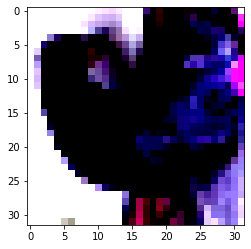

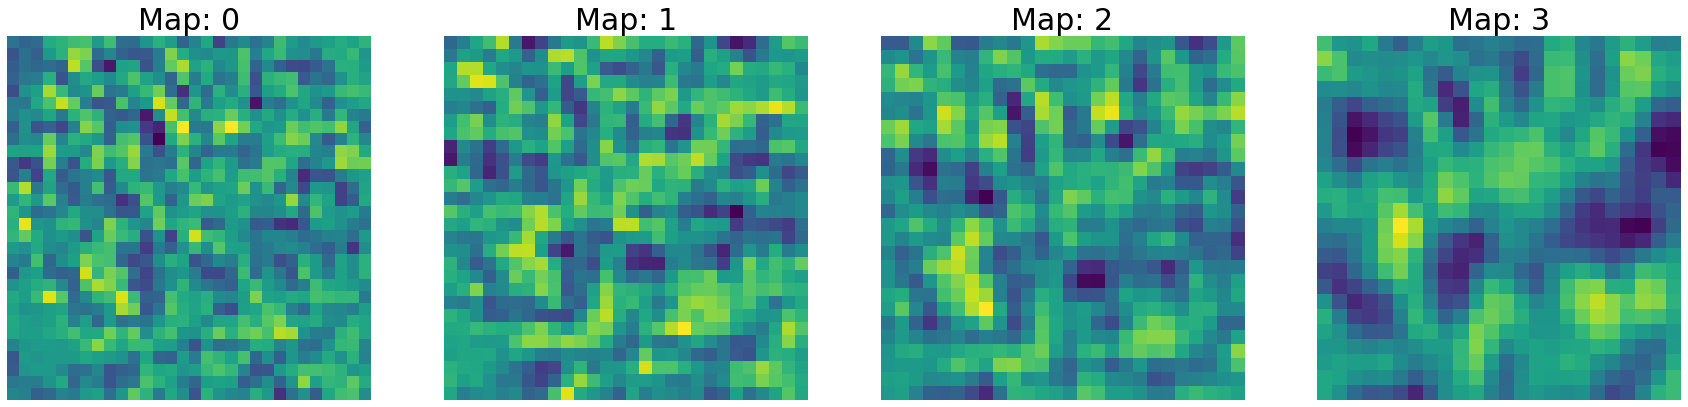

In [24]:

# Evaluations

# num layers
print("Normal CNN")
print("---------------------------------------------------------------------------\n")
runAblation(CNN(), batchSize=64, lr=0.001, numEpochs=10)
print()

print("Short CNN")
print("---------------------------------------------------------------------------\n")
runAblation(shortCNN(), batchSize=64, lr=0.001, numEpochs=10)
print()

print("Normal CNN")
print("---------------------------------------------------------------------------\n")
runAblation(longerCNN(), batchSize=64, lr=0.001, numEpochs=10)
print()


In [37]:
# conv filter size

%matplotlib inline

# num layers
print("5x5 filter CNN")
print("---------------------------------------------------------------------------\n")
runAblation(wideCNN(), batchSize=64, lr=0.001, numEpochs=10)
print()

print("7x7 filter CNN")
print("---------------------------------------------------------------------------\n")
runAblation(hugeCNN(), batchSize=64, lr=0.001, numEpochs=10)
print()

print("Mixed filter size CNN")
print("---------------------------------------------------------------------------\n")
runAblation(mixedCNN(), batchSize=64, lr=0.001, numEpochs=10)
print()

KeyError: ignored

Without dropout
---------------------------------------------------------------------------

Files already downloaded and verified
Files already downloaded and verified
10
Epoch [1/10], Loss: {:1.7079}
Epoch [2/10], Loss: {:1.4965}
Epoch [3/10], Loss: {:1.4797}
Epoch [4/10], Loss: {:0.8173}
Epoch [5/10], Loss: {:1.1078}
Epoch [6/10], Loss: {:0.8132}
Epoch [7/10], Loss: {:1.1975}
Epoch [8/10], Loss: {:0.7400}
Epoch [9/10], Loss: {:1.1907}
Epoch [10/10], Loss: {:1.1005}


Accuracy on 10000 training images: 64.030%
F1 score for all classes:  [0.69047619 0.71951886 0.5250887  0.45776851 0.58829465 0.54318418
 0.7277677  0.70612038 0.73952096 0.68614431]

Time taken: 3.752415 minutes

Feature maps: 
4 conv layers found:
Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))

torch.Size([32, 32, 3])
4 feature maps of the following shapes: 
torch.Size([1, 32, 30, 30])
torch.Size([1, 32, 28, 28])
torch.Size([1, 64, 26, 26])
torch.Size([1, 64, 24, 24])

Feature map shapes
(30, 30)
(28, 28)
(26, 26)
(24, 24)

With dropout
---------------------------------------------------------------------------

Files already downloaded and verified
Files already downloaded and verified
10
Epoch [1/10], Loss: {:1.7233}
Epoch [2/10], Loss: {:1.7088}
Epoch [3/10], Loss: {:1.3150}
Epoch [4/10], Loss: {:1.2577}
Epoch [5/10], Loss: {:1.327

Accuracy on 10000 training images: 60.430%
F1 score for all classes:  [0.62745098 0.72770398 0.47351351 0.41139896 0.5115493  0.52115385
 0.6746988  0.66092245 0.70961804 0.6808933 ]

Time taken: 3.771510 minutes

Feature maps: 
4 conv layers found:
Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))

torch.Size([32, 32, 3])
4 feature maps of the following shapes: 
torch.Size([1, 32, 30, 30])
torch.Size([1, 32, 28, 28])
torch.Size([1, 64, 26, 26])
torch.Size([1, 64, 24, 24])

Feature map shapes
(30, 30)
(28, 28)
(26, 26)
(24, 24)



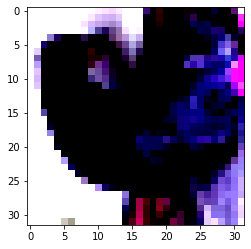

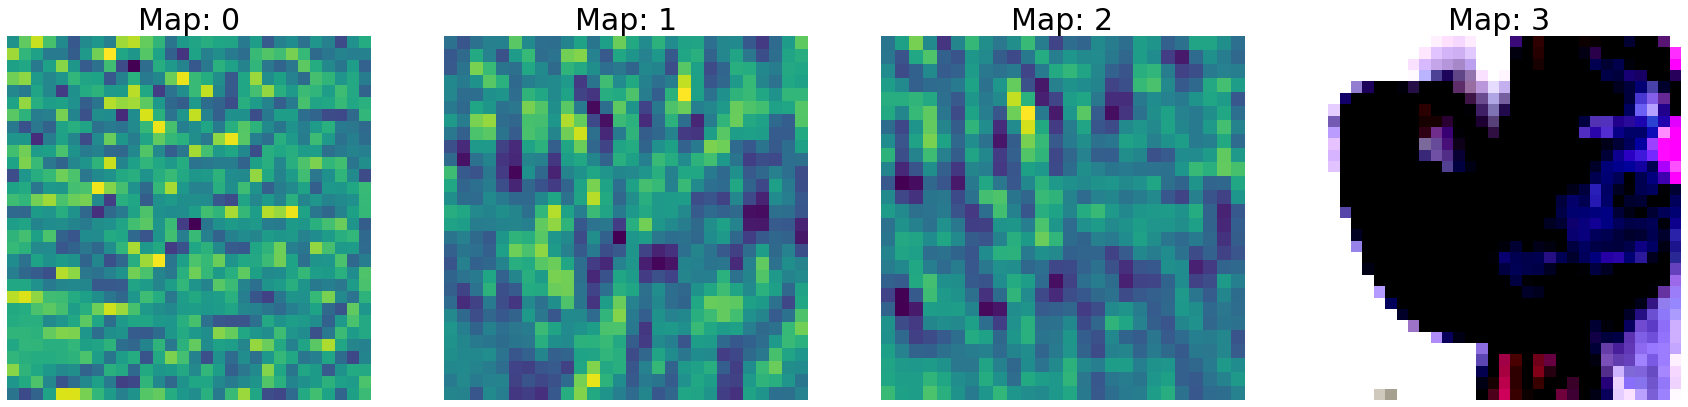

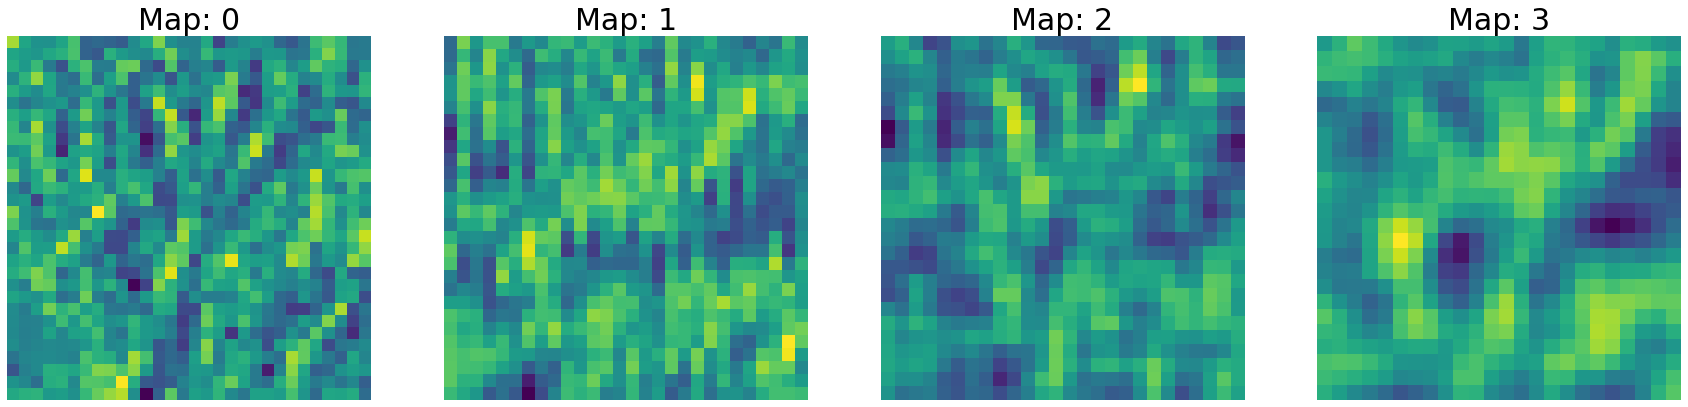

In [34]:
# dropout layers

print("Without dropout")
print("---------------------------------------------------------------------------\n")
runAblation(CNN(), batchSize=64, lr=0.001, numEpochs=10)
print()

print("With dropout")
print("---------------------------------------------------------------------------\n")
runAblation(dropoutCNN(), batchSize=64, lr=0.001, numEpochs=10)
print()


Higher lr
---------------------------------------------------------------------------

Files already downloaded and verified
Files already downloaded and verified
10
Epoch [1/10], Loss: {:1.3006}
Epoch [2/10], Loss: {:2.0628}
Epoch [3/10], Loss: {:1.3166}
Epoch [4/10], Loss: {:1.4633}
Epoch [5/10], Loss: {:1.1462}
Epoch [6/10], Loss: {:0.7489}
Epoch [7/10], Loss: {:0.9630}
Epoch [8/10], Loss: {:0.9538}
Epoch [9/10], Loss: {:0.3463}
Epoch [10/10], Loss: {:0.5763}


Accuracy on 10000 training images: 68.480%
F1 score for all classes:  [0.72610837 0.80605487 0.58044164 0.50196464 0.63847981 0.56662934
 0.77159881 0.72302905 0.79422023 0.74389551]

Time taken: 3.587912 minutes

Feature maps: 
4 conv layers found:
Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))

torch.Size([32, 32, 3])
4 feature maps of the following shapes: 
torch.Size([1, 32, 30, 30])
torch.Size([1, 32, 28, 28])
torch.Size([1, 64, 26, 26])
torch.Size([1, 64, 24, 24])

Feature map shapes
(30, 30)
(28, 28)
(26, 26)
(24, 24)

Lower lr
---------------------------------------------------------------------------

Files already downloaded and verified
Files already downloaded and verified
10
Epoch [1/10], Loss: {:1.9459}
Epoch [2/10], Loss: {:1.5817}
Epoch [3/10], Loss: {:1.7550}
Epoch [4/10], Loss: {:1.4386}
Epoch [5/10], Loss: {:1.2713}
E

Accuracy on 10000 training images: 59.170%
F1 score for all classes:  [0.65693431 0.70158103 0.46511628 0.43518519 0.46491763 0.48213333
 0.64963504 0.6584976  0.71923077 0.64109848]

Time taken: 3.518480 minutes

Feature maps: 
4 conv layers found:
Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))

torch.Size([32, 32, 3])
4 feature maps of the following shapes: 
torch.Size([1, 32, 30, 30])
torch.Size([1, 32, 28, 28])
torch.Size([1, 64, 26, 26])
torch.Size([1, 64, 24, 24])

Feature map shapes
(30, 30)
(28, 28)
(26, 26)
(24, 24)

Higher batchsize
---------------------------------------------------------------------------

Files already downloaded and verified
Files already downloaded and verified
10
Epoch [1/10], Loss: {:1.8201}
Epoch [2/10], Loss: {:1.7287}
Epoch [3/10], Loss: {:1.3201}
Epoch [4/10], Loss: {:1.4803}
Epoch [5/10], Loss: {:1

Accuracy on 10000 training images: 58.970%
F1 score for all classes:  [0.65483871 0.7031333  0.4509915  0.42974492 0.50493506 0.44574096
 0.68561119 0.64878543 0.71353919 0.63425513]

Time taken: 3.336857 minutes

Feature maps: 
4 conv layers found:
Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))

torch.Size([32, 32, 3])
4 feature maps of the following shapes: 
torch.Size([1, 32, 30, 30])
torch.Size([1, 32, 28, 28])
torch.Size([1, 64, 26, 26])
torch.Size([1, 64, 24, 24])

Feature map shapes
(30, 30)
(28, 28)
(26, 26)
(24, 24)

Lower batchsize
---------------------------------------------------------------------------

Files already downloaded and verified
Files already downloaded and verified
10
Epoch [1/10], Loss: {:1.2842}
Epoch [2/10], Loss: {:0.8819}
Epoch [3/10], Loss: {:1.4865}
Epoch [4/10], Loss: {:0.8633}
Epoch [5/10], Loss: {:0.

Accuracy on 10000 training images: 68.380%
F1 score for all classes:  [0.71841542 0.80813953 0.56551724 0.49202265 0.63255814 0.58931019
 0.74831157 0.73416407 0.78800857 0.76687117]

Time taken: 4.034219 minutes

Feature maps: 
4 conv layers found:
Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))

torch.Size([32, 32, 3])
4 feature maps of the following shapes: 
torch.Size([1, 32, 30, 30])
torch.Size([1, 32, 28, 28])
torch.Size([1, 64, 26, 26])
torch.Size([1, 64, 24, 24])

Feature map shapes
(30, 30)
(28, 28)
(26, 26)
(24, 24)

Higher epochnum
---------------------------------------------------------------------------

Files already downloaded and verified
Files already downloaded and verified
15
Epoch [1/15], Loss: {:1.5525}
Epoch [2/15], Loss: {:1.6514}
Epoch [3/15], Loss: {:1.1812}
Epoch [4/15], Loss: {:1.2882}
Epoch [5/15], Loss: {:1.

Accuracy on 10000 training images: 67.920%
F1 score for all classes:  [0.72064394 0.79694656 0.54715998 0.46655232 0.61686233 0.56951744
 0.75858636 0.72470588 0.80019637 0.75011809]

Time taken: 4.809676 minutes

Feature maps: 
4 conv layers found:
Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))

torch.Size([32, 32, 3])
4 feature maps of the following shapes: 
torch.Size([1, 32, 30, 30])
torch.Size([1, 32, 28, 28])
torch.Size([1, 64, 26, 26])
torch.Size([1, 64, 24, 24])

Feature map shapes
(30, 30)
(28, 28)
(26, 26)
(24, 24)

Lower epochnum
---------------------------------------------------------------------------

Files already downloaded and verified
Files already downloaded and verified
5
Epoch [1/5], Loss: {:1.5020}
Epoch [2/5], Loss: {:2.6641}
Epoch [3/5], Loss: {:1.9526}
Epoch [4/5], Loss: {:1.0161}
Epoch [5/5], Loss: {:1.1973}


Accuracy on 10000 training images: 56.600%
F1 score for all classes:  [0.63035431 0.67357513 0.39493671 0.42252363 0.52050919 0.44051251
 0.6539075  0.63070943 0.67414634 0.58902878]

Time taken: 1.651100 minutes

Feature maps: 
4 conv layers found:
Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))

torch.Size([32, 32, 3])
4 feature maps of the following shapes: 
torch.Size([1, 32, 30, 30])
torch.Size([1, 32, 28, 28])
torch.Size([1, 64, 26, 26])
torch.Size([1, 64, 24, 24])

Feature map shapes
(30, 30)
(28, 28)
(26, 26)
(24, 24)



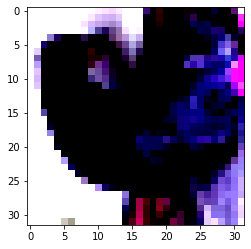

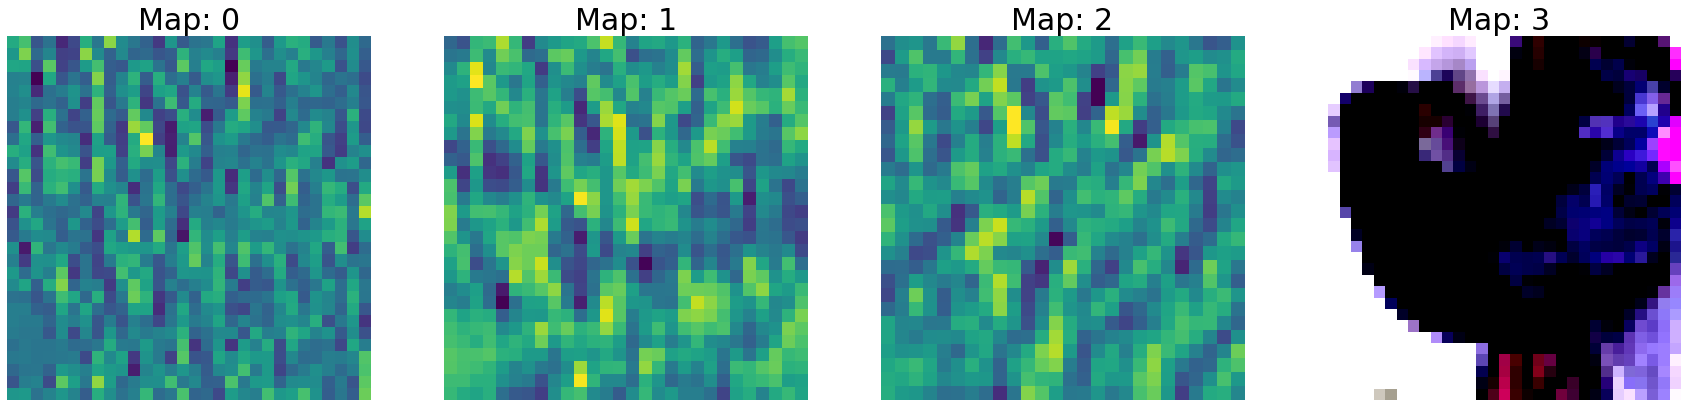

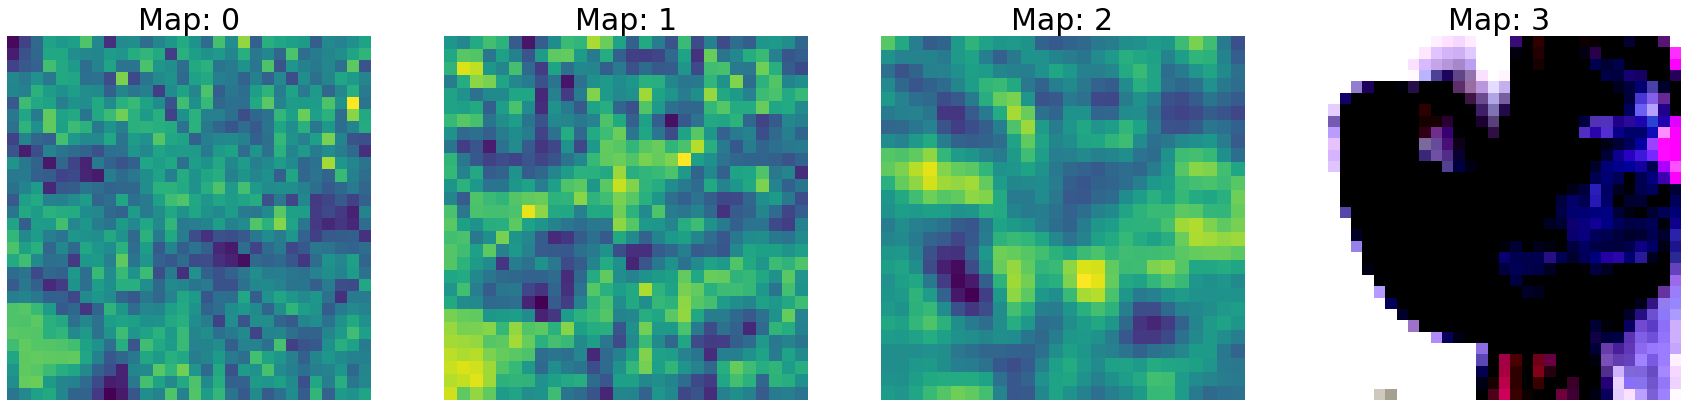

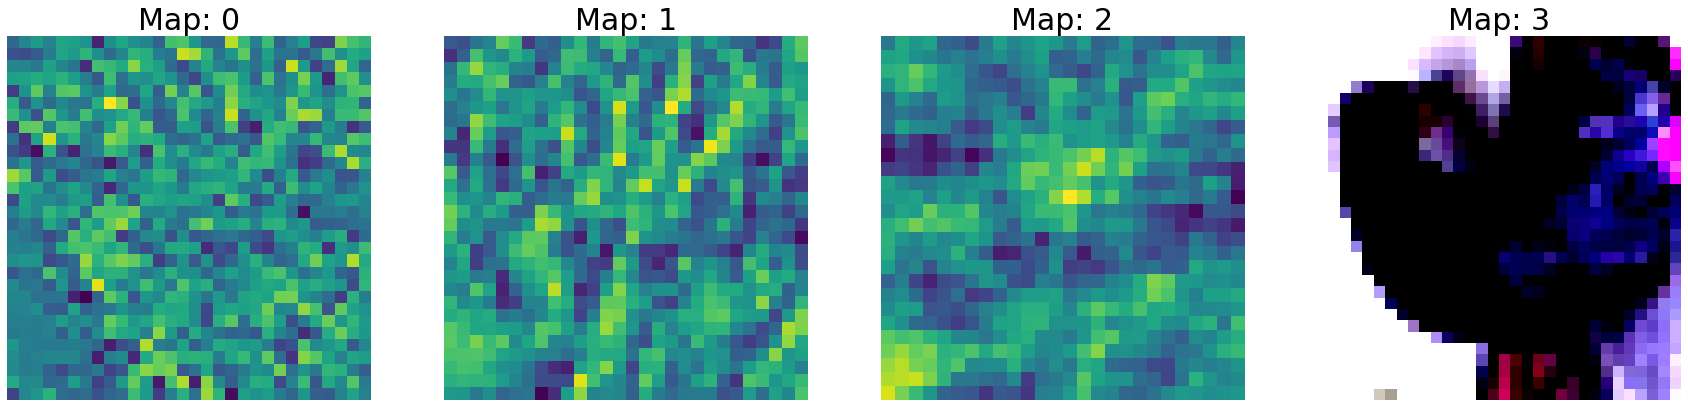

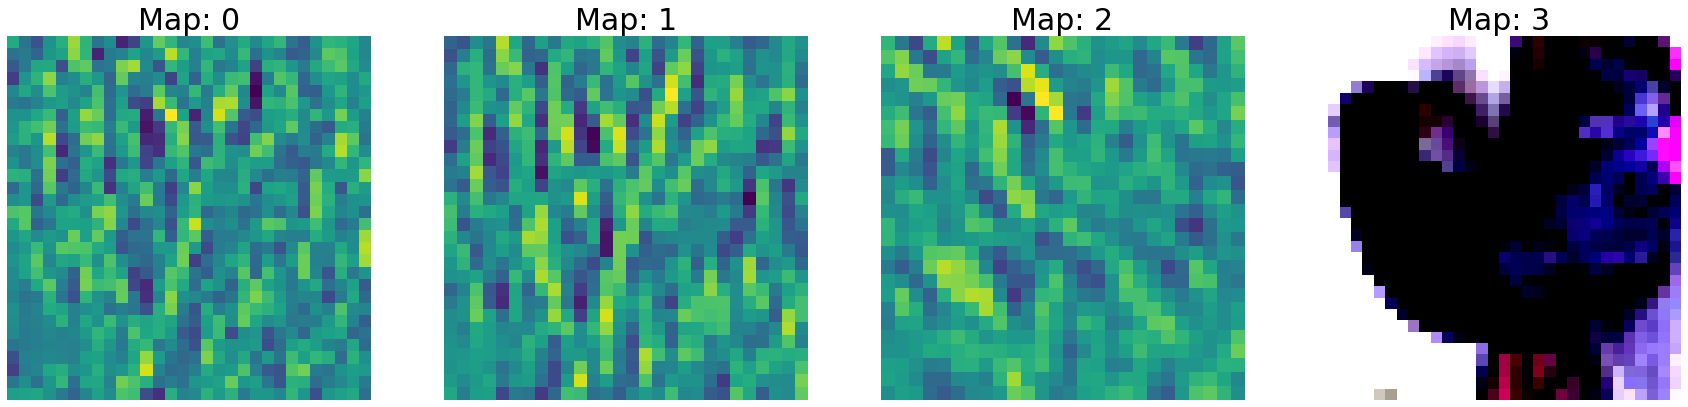

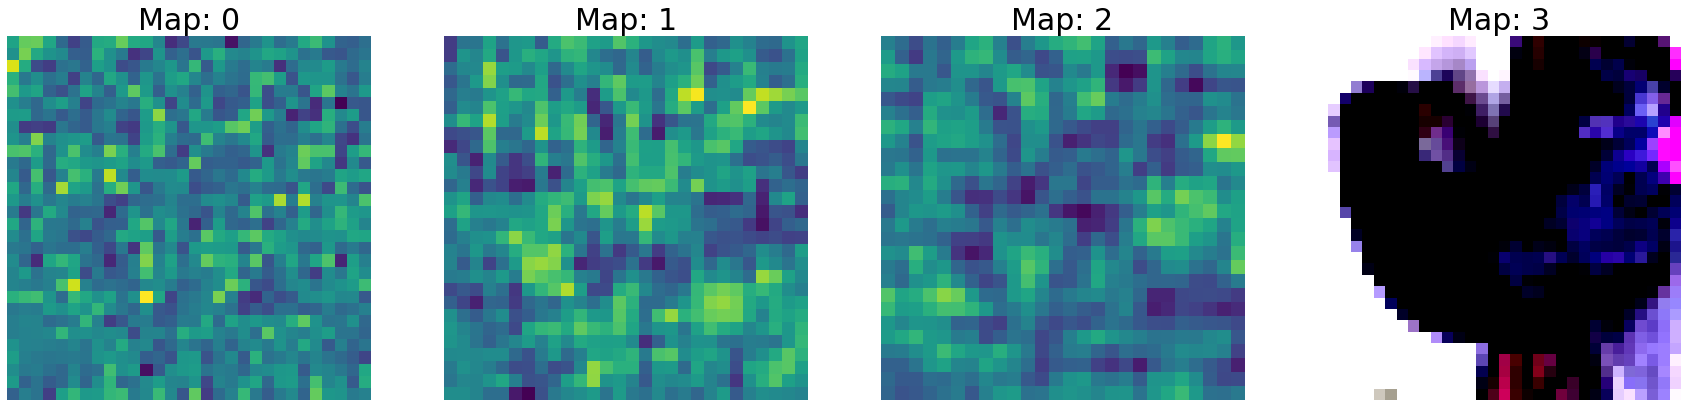

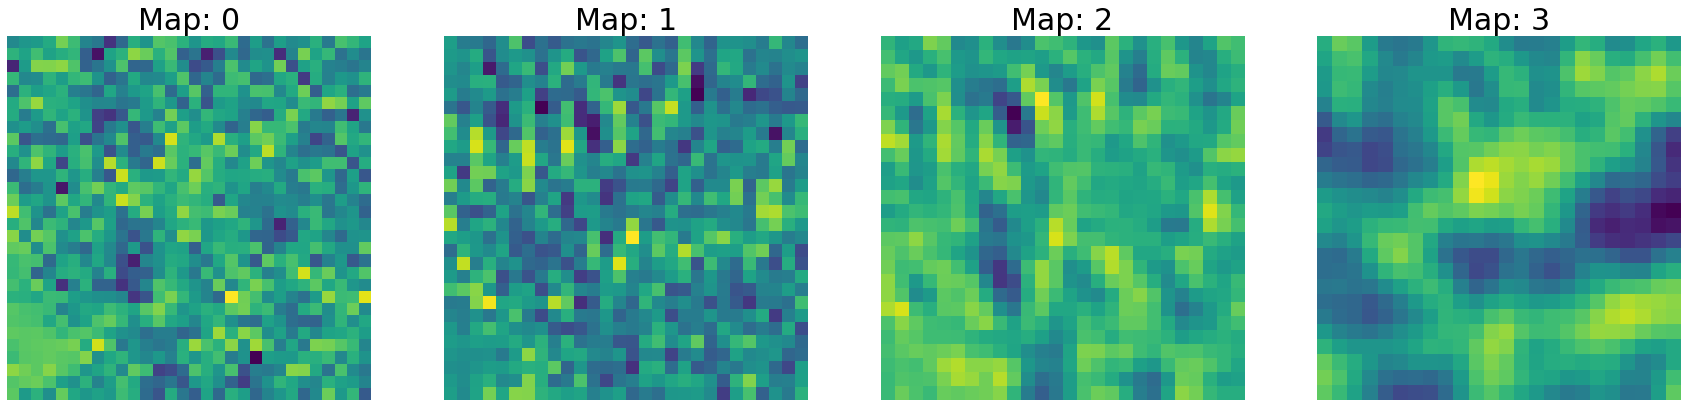

In [35]:
# vary hyper params

# lr
%matplotlib inline
print("Higher lr")
print("---------------------------------------------------------------------------\n")
runAblation(CNN(), batchSize=64, lr=0.002, numEpochs=10)
print()

print("Lower lr")
print("---------------------------------------------------------------------------\n")
runAblation(CNN(), batchSize=64, lr=0.0005, numEpochs=10)
print()

print("Higher batchsize")
print("---------------------------------------------------------------------------\n")
runAblation(CNN(), batchSize=128, lr=0.001, numEpochs=10)
print()

print("Lower batchsize")
print("---------------------------------------------------------------------------\n")
runAblation(CNN(), batchSize=32, lr=0.001, numEpochs=10)
print()


print("Higher epochnum")
print("---------------------------------------------------------------------------\n")
runAblation(CNN(), batchSize=64, lr=0.001, numEpochs=15)
print()

print("Lower epochnum")
print("---------------------------------------------------------------------------\n")
runAblation(CNN(), batchSize=64, lr=0.001, numEpochs=5)
print()